<a href="https://colab.research.google.com/github/aleksey-sut/portfolio/blob/main/NN_for_digit_recogn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Делаем модель нейросети для распознавания рукописных цифр**

Структура сети будет следующей. Каждое изображение размером 28x28 пикселей растянем в вектор длиной 784 элемента и подадим на первый слой из 128 нейронов с функцией активации ReLU:  
Далее разместим еще один слой из 10 выходных нейронов с функцией активации softmax. Полученный выходной вектор как раз и будет содержать класс предъявленного изображения.   


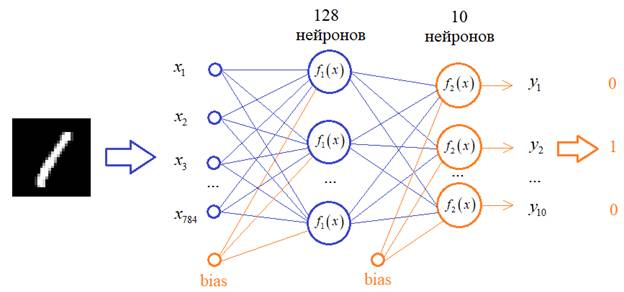

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

Загрузим обучающий и тестовый наборы с помощью функции load_data():

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
x_train.shape

(60000, 28, 28)

Послеэтого, значения пикселей нужно привести к диапазону [0; 1] и вытянуть в векторы длины 28*28 = 784 элемента:

In [4]:
x_train = x_train / 255
x_test = x_test / 255
 
x_train = tf.reshape(tf.cast(x_train, tf.float32), [-1, 28*28]) # cast - меняем формат на вещественный, reshape - вытягиваем матрицу 28х28в вектор 
x_test = tf.reshape(tf.cast(x_test, tf.float32), [-1, 28*28])
 
y_train = to_categorical(y_train, 10)

In [5]:
x_train.shape

TensorShape([60000, 784])

Создадим модель полносвязного слоя НС

In [6]:
class DenseNN(tf.Module):
    def __init__(self, outputs, activate="relu"):
        super().__init__()
        self.outputs = outputs
        self.activate = activate
        self.fl_init = False
 
    def __call__(self, x):
        if not self.fl_init:
            self.w = tf.random.truncated_normal((x.shape[-1], self.outputs), stddev=0.1, name="w")
            self.b = tf.zeros([self.outputs], dtype=tf.float32, name="b")
 
            self.w = tf.Variable(self.w)
            self.b = tf.Variable(self.b)
 
            self.fl_init = True
 
        y = x @ self.w + self.b
 
        if self.activate == "relu":
            return tf.nn.relu(y)
        elif self.activate == "softmax":
            return tf.nn.softmax(y)
 
        return y

Второй важный момент – простота управлением обучаемых и необучаемых параметров. Давайте, ради интереса, сделаем биасы (biases) необучаемыми. Для этого в методе __call__ класса DenseNN достаточно добавить параметр trainable=False у соответствующего тензора:  
self.b = tf.Variable(self.b, trainable=False)

Далее, мы создадим два полносвязных слоя со 128 нейронами и 10:

In [7]:
layer_1 = DenseNN(128)
layer_2 = DenseNN(10, activate="softmax")

определим функцию вычисления выходных значений НС при заданных входных x:

In [8]:
def model_predict(x):
    y = layer_1(x)
    y = layer_2(y)
    return y            # layer_2(layer_1(x))

Фактически, нам осталось обучить эту НС, то есть, найти значения параметров весовых коэффициентов с помощью алгоритма градиентного спуска. Как мы уже хорошо себе представляем, для этого вначале нужно задать функцию потерь. В задачах классификации (с числом классов более 2) хорошо себя зарекомендовала категориальная кросс-энтропия. В пакете Tensorflow она уже встроена и нам достаточно описать порядок ее вызова. Сделаемэто, следующимобразом:

In [9]:
cross_entropy = lambda y_true, y_pred: tf.reduce_mean(tf.losses.categorical_crossentropy(y_true, y_pred))

Далее, определим оптимизатор для градиентного спуска. Пусть это будет Adam, как наиболее употребительный в задачах обучения НС с шагом обучения 0,001:

In [10]:
opt = tf.optimizers.Adam(learning_rate=0.001)

Затем, запускаем сам алгоритм обучения. Вначале для его работы определим параметры:

In [11]:
BATCH_SIZE = 32
EPOCHS = 10
TOTAL = x_train.shape[0]

Делаем разбивку по мини-батчам с перемешиванием выборки:

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

И реализуем цикл обучения, следующим образом:

In [13]:
for n in range(EPOCHS):
    loss = 0
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model_predict(x_batch)) #Задаем функцию потерь
 
        loss += f_loss
        grads = tape.gradient(f_loss, [layer_1.trainable_variables, layer_2.trainable_variables]) #прямой проход по графу вычислений для заданной функции f_loss
        opt.apply_gradients(zip(grads[0], layer_1.trainable_variables)) #Применяем оптимизатор Адам к коэфф 1-го слоя (изменяем их с помощью метода apply_gradients())
        opt.apply_gradients(zip(grads[1], layer_2.trainable_variables)) #Применяем оптимизатор Адам к коэфф 2-го слоя (изменяем их с помощью метода apply_gradients())
 
    print(loss.numpy())

464.02728
196.83351
136.29097
102.99501
78.38199
61.52218
47.75828
38.21219
31.077429
26.557768


оценим качество работы обученной НС на тестовой выборке:

In [14]:
y = model_predict(x_test)
y2 = tf.argmax(y, axis=1).numpy()
acc = len(y_test[y_test == y2])/y_test.shape[0] * 100
print(acc)

97.75


Эту же метрику можно посчитать и средствами Tensorflow, используя класс Accuracy(), следующим образом:

In [15]:
acc = tf.metrics.Accuracy()
acc.update_state(y_test, y2)
print(acc.result().numpy() * 100 )

97.75000214576721


# Вложенные модели

С помощью того же базового класса tf.Module можно создавать и вложенные (многоуровневые) модели. Именно так было бы правильнее реализовать общую модель двухслойной НС:

In [ ]:
class SequentialModule(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = DenseNN(128)
        self.layer_2 = DenseNN(10, activate="softmax")
 
    def __call__(self, x):
        return self.layer_2(self.layer_1(x))

In [ ]:
model = SequentialModule()

при вычислении градиентов достаточно указать единый список обучаемых параметров:

In [ ]:
for n in range(EPOCHS):
    loss = 0
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model_predict(x_batch)) #Задаем функцию потерь
 
        loss += f_loss
        grads = tape.gradient(f_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
 
    print(loss.numpy())

35.332214
35.33218
35.33222
35.3322
35.3322
35.332214
35.332214
35.3322
35.332172
35.33225


Здесь коллекция trainable_variables формируется автоматически из тех переменных тензоров (tf.Variable), которые присутствуют в слоях. Таким образом, мы переходим на более высокий уровень абстракции и, как следствие, получаем большую гибкость программы и удобство ее использования.Мало того, у моделиSequentialModule имеется свойствоsubmodules, которое содержит список вложенных моделей:

In [ ]:
print(model.submodules)

(<__main__.DenseNN object at 0x7f3bcdf74fd0>, <__main__.DenseNN object at 0x7f3bcdf74f70>)


Усовершенствуем класс SequentialModule(tf.Module), добавим возможность устанавливать производное число слоев

In [16]:
class SequentialModule(tf.Module):
    def __init__(self, layer_list):
        super().__init__()
        self.layer_list = layer_list
         
    def __call__(self, x):
      y = self.layer_list[0](x)
      for layer in self.layer_list[1:]:
        y = layer(y)
        return y

In [17]:
model = SequentialModule([DenseNN(64), DenseNN(128), DenseNN(10, activate="softmax")])

In [19]:
for n in range(EPOCHS):
    loss = 0
    for x_batch, y_batch in train_dataset:
        with tf.GradientTape() as tape:
            f_loss = cross_entropy(y_batch, model_predict(x_batch)) #Задаем функцию потерь
 
        loss += f_loss
        grads = tape.gradient(f_loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
 
    print(loss.numpy())

29.247234
29.24722
29.247229
29.247223
29.247225
29.247234
29.247229
29.24723
29.247242
29.247213


In [18]:
print(model.submodules)

(<__main__.DenseNN object at 0x7f9e462d88b0>, <__main__.DenseNN object at 0x7f9e462d8b80>, <__main__.DenseNN object at 0x7f9e462d8c10>)


# Декоратор tf.function для ускорения выполнения функций

На предыдущем занятии мы с вами построили двухслойную полносвязную НС для классификации изображений цифр. И написали свою процедуру обучения этой сети средствами Tensorflow. Но один важный нюанс остался в стороне – это перенос вычислений на уровень графов для ускорения расчетов. В Tensorflow любой набор операций можно перевести в графовое представление и выполнять более эффективно.

Первый вопрос, который здесь может возникнуть, что такое графы в Tensorflow? В двух словах – это представление процесса вычислений в виде последовательности распределенных операций tf.Operation с тензорами tf.Tensor:
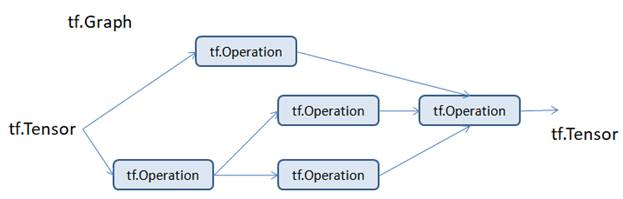

Не следует путать эту структуру с вычислительным графом в автоматическом дифференцировании. Это разные вещи. Здесь подразумевается, что любой фрагмент программы, написанный с использованием Tensorflow, можно представить в виде такого графа операций. Например, в программе обучения НС есть ресурсоемкий фрагмент расчета производных и изменения обучаемых параметров:

In [20]:
@tf.function # декоратор
def train_batch(x_batch, y_batch):
    with tf.GradientTape() as tape:
        f_loss = cross_entropy(y_batch, model(x_batch))
 
    grads = tape.gradient(f_loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
 
    return f_loss

In [21]:
for n in range(EPOCHS):
    loss = 0
    for x_batch, y_batch in train_dataset:
        loss += train_batch(x_batch, y_batch)
 
    print(loss.numpy())

ValueError: ignored

После запуска программы увидим заметное ускорение процесса обучения.

Ускорение вычислений в таких графах происходит за счет:

статические (неизменяемые) вычисления выполняются один раз и, затем, многократно используются;
независимые вычисления разделяются между потоками и устройствами (например, графическими процессорами);
общие арифметические операции выполняются только один раз.
Кроме того, граф Tensorflow можно использовать в других средах без интерпретатора Python, например, в мобильных устройствах, используя язык Java.